In [14]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

DATA_DIR = '/kaggle/input'
# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
%matplotlib inline
#hi
project_name = "MarinAI"

In [15]:
image_size = 256
batch_size = 32
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
dataset = ImageFolder(DATA_DIR+'/marinadataset/MarinaDataset', transform= tt.Compose([
    tt.Resize(image_size),
    tt.RandomHorizontalFlip(),
    tt.RandomVerticalFlip(),
    #tt.RandomPerspective(distortion_scale=0.2),
    tt.RandomCrop(256, padding=4),
    tt.ColorJitter(0.5, 0.5, 0.5, 0.2),
    #tt.CenterCrop(image_size),
    tt.ToTensor()]))

In [16]:
img, label = dataset[300]
print(img.shape, label)
img

torch.Size([3, 256, 256]) 0


tensor([[[0.0235, 0.0235, 0.0235,  ..., 0.0235, 0.0235, 0.0235],
         [0.0235, 0.0235, 0.0235,  ..., 0.0549, 0.0549, 0.0549],
         [0.0235, 0.0235, 0.0235,  ..., 0.0549, 0.0549, 0.0549],
         ...,
         [0.0235, 0.0235, 0.0235,  ..., 0.0588, 0.0588, 0.0588],
         [0.0235, 0.0235, 0.0235,  ..., 0.0588, 0.0588, 0.0588],
         [0.0235, 0.0235, 0.0235,  ..., 0.0588, 0.0588, 0.0588]],

        [[0.0235, 0.0235, 0.0235,  ..., 0.0235, 0.0235, 0.0235],
         [0.0235, 0.0235, 0.0235,  ..., 0.0941, 0.0980, 0.0980],
         [0.0235, 0.0235, 0.0235,  ..., 0.0941, 0.0941, 0.0980],
         ...,
         [0.0235, 0.0235, 0.0235,  ..., 0.0980, 0.0980, 0.0980],
         [0.0235, 0.0235, 0.0235,  ..., 0.1020, 0.1020, 0.1020],
         [0.0235, 0.0235, 0.0235,  ..., 0.0980, 0.0980, 0.0980]],

        [[0.0235, 0.0235, 0.0235,  ..., 0.0235, 0.0235, 0.0235],
         [0.0235, 0.0235, 0.0235,  ..., 0.0745, 0.0745, 0.0745],
         [0.0235, 0.0235, 0.0235,  ..., 0.0745, 0.0745, 0.

In [17]:
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  Clean (0)
725


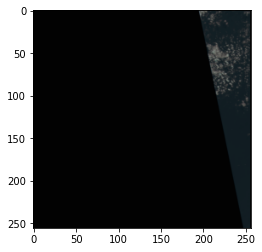

In [18]:
show_example(*dataset[0])
print(len(dataset))

In [19]:
val_size = 200
train_size = len(dataset) - val_size

random_seed = 42
torch.manual_seed(random_seed);

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(525, 200)

In [20]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)

In [21]:
def accuracy(predictions, labels):
    classes = torch.argmax(predictions, dim=1)
    return torch.mean((classes == labels).float())

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
       
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()  # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [22]:
class Cifar10CnnModel(ImageClassificationBase):
        def __init__(self):
            super().__init__()
            self.network = nn.Sequential(
                nn.Conv2d(3, 32, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2, 2), # outpugasgfst: 64 x 128 x 128

                nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2, 2), # output: 128 x 64 x 64

                nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2, 2), # output: 256 x 32 x 32

                nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2, 2), # output: 512 x 16 x 16

                nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2, 2), # output: 1024 x 8 x 8

                nn.Conv2d(1024, 2048, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.Conv2d(2048, 2048, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2), # output: 2048 x 4 x 4

                nn.Flatten(), 
                nn.Linear(2048*4*4, 1024),
                nn.ReLU(),
                nn.Linear(1024, 8),
                nn.ReLU(),
                nn.Linear(8, 2))
               

        
        def forward(self, xb):
                return self.network(xb)

In [23]:
model = Cifar10CnnModel()
model

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): ReLU()
    (17): Conv2d(512, 512, kernel_size=(3, 3), stride=

In [24]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [25]:
device = get_default_device()
device

device(type='cuda')

In [26]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

In [27]:
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [28]:
model = to_device(Cifar10CnnModel(), device)

In [29]:
evaluate(model, val_dl)

{'val_loss': 0.6901301741600037, 'val_acc': 0.55078125}

In [30]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.0001

In [31]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.7048, val_loss: 0.6706, val_acc: 0.8281
Epoch [1], train_loss: 0.6285, val_loss: 0.5262, val_acc: 0.7578
Epoch [2], train_loss: 0.4804, val_loss: 0.4755, val_acc: 0.8633
Epoch [3], train_loss: 0.4202, val_loss: 0.3620, val_acc: 0.8516
Epoch [4], train_loss: 0.4165, val_loss: 0.3608, val_acc: 0.7734
Epoch [5], train_loss: 0.3658, val_loss: 0.2972, val_acc: 0.8320
Epoch [6], train_loss: 0.3271, val_loss: 0.3320, val_acc: 0.8281
Epoch [7], train_loss: 0.3555, val_loss: 0.2828, val_acc: 0.8477
Epoch [8], train_loss: 0.3618, val_loss: 0.3164, val_acc: 0.8750
Epoch [9], train_loss: 0.2401, val_loss: 0.1872, val_acc: 0.9570


In [32]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

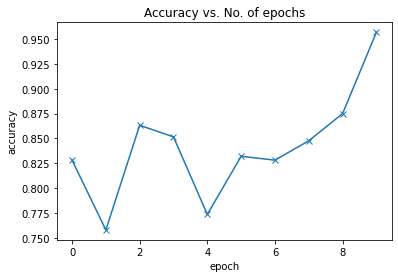

In [33]:
plot_accuracies(history)

In [34]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

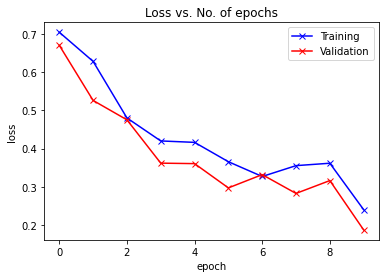

In [35]:
plot_losses(history)